In [2]:
import pandas as pd

# Load your data
data = pd.read_csv('../../data/student-graduation/graduation_dataset.csv')

# Feature extraction
data['Total Credits'] = data['Curricular units 1st sem (credited)'] + data['Curricular units 2nd sem (credited)']
data['Total Enrolled Units'] = data['Curricular units 1st sem (enrolled)'] + data['Curricular units 2nd sem (enrolled)']
data['Total Approved Units'] = data['Curricular units 1st sem (approved)'] + data['Curricular units 2nd sem (approved)']

# Calculate average grades for students who have grades available
data['Average Grade'] = data[['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']].mean(axis=1)

# Binary features for key indicators
data['Is International Student'] = data['International'].apply(lambda x: 1 if x == 1 else 0)
data['Is Debtor'] = data['Debtor'].apply(lambda x: 1 if x == 1 else 0)
data['Has Scholarship'] = data['Scholarship holder'].apply(lambda x: 1 if x == 1 else 0)

# Display the new features
new_features = ['Total Credits', 'Total Enrolled Units', 'Total Approved Units', 
                'Average Grade', 'Is International Student', 'Is Debtor', 'Has Scholarship']

print("Extracted Features:")
print(data[new_features].head())


Extracted Features:
   Total Credits  Total Enrolled Units  Total Approved Units  Average Grade  \
0              0                     0                     0       0.000000   
1              0                    12                    12      13.833333   
2              0                    12                     0       0.000000   
3              0                    12                    11      12.914286   
4              0                    12                    11      12.666667   

   Is International Student  Is Debtor  Has Scholarship  
0                         0          0                0  
1                         0          0                0  
2                         0          0                0  
3                         0          0                0  
4                         0          0                0  


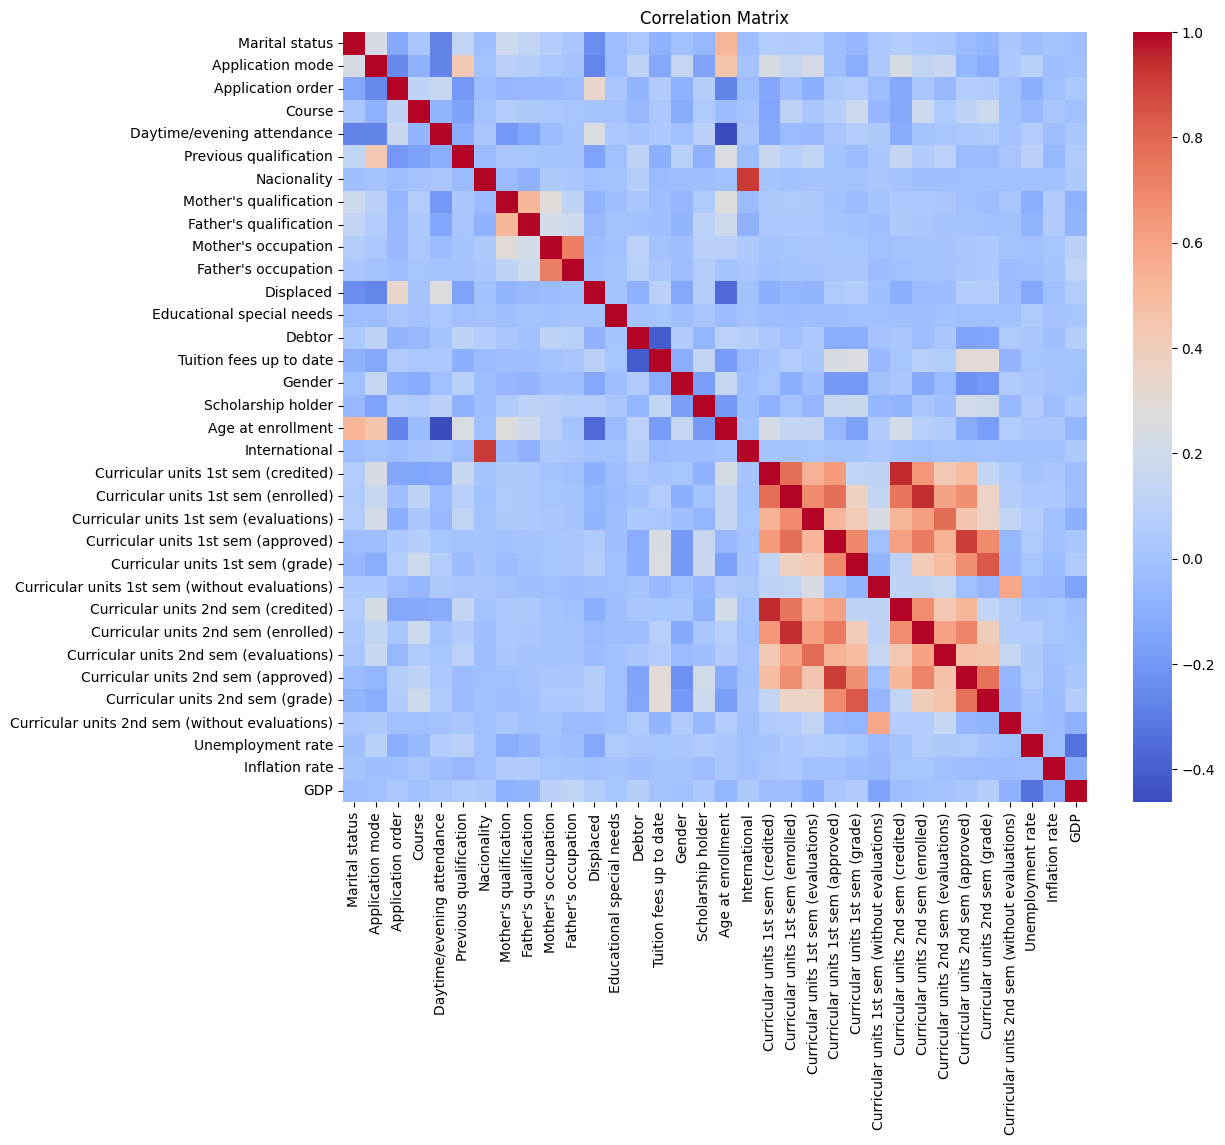

Dropped highly correlated features: []
Top selected features (Univariate Selection): Index(['Application mode', 'Debtor', 'Tuition fees up to date', 'Gender',
       'Scholarship holder', 'Age at enrollment',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)'],
      dtype='object')
Top features based on Random Forest importance:
                                   Feature  Importance
28     Curricular units 2nd sem (approved)    0.139524
29        Curricular units 2nd sem (grade)    0.108936
22     Curricular units 1st sem (approved)    0.093029
23        Curricular units 1st sem (grade)    0.074309
27  Curricular units 2nd sem (evaluations)    0.048938
17                       Age at enrollment    0.042033
21  Curricular units 1st sem (evaluations)    0.039941
14                 Tuition fees up to date    0.038683
3                                   Course    0

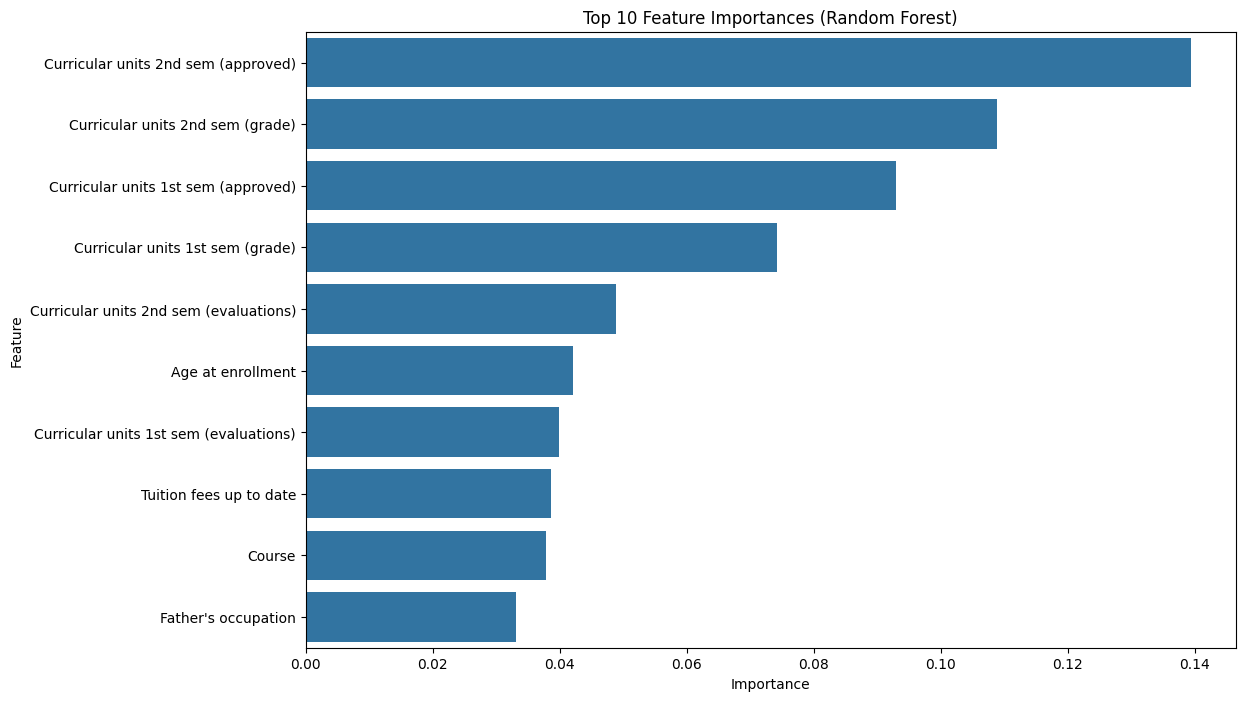

Number of components explaining 78% of the variance: 2
Cumulative explained variance with selected components: 1.00


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,6.929830,-14.630792,2.588903,1.586110,0.682232,-0.019738,0.479989,0.106842,-0.325864,0.084776
1,-6.400839,1.926394,0.990603,-0.434628,-0.112299,0.055164,0.844427,-0.125811,0.559033,-0.743367
2,3.721459,-16.870410,-3.292210,1.770483,0.690016,-0.128486,0.591931,-0.031179,0.383850,-0.637595
3,-4.122742,1.699481,2.364488,-0.535454,-0.669165,-0.411293,-0.212742,-0.351779,-0.185905,-0.008009
4,16.166668,14.957812,-4.794142,-0.989158,1.230975,1.012594,-0.328943,-0.256731,-0.230831,0.032743


In [4]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('../../data/student-graduation/graduation_dataset.csv')

# Assuming 'Target_Graduate' is the target column for prediction
X = data.drop(columns=['Target'])
y = data['Target']

# 1. Correlation Analysis to Drop Highly Correlated Features
correlation_matrix = X.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Find highly correlated features (correlation coefficient > 0.8)
high_corr_features = [column for column in correlation_matrix.columns if any(abs(correlation_matrix[column]) > 0.8) and column != correlation_matrix.columns[correlation_matrix.columns.get_loc(column)]]

# Drop highly correlated features
X = X.drop(columns=high_corr_features)
print("Dropped highly correlated features:", high_corr_features)

# 2. Univariate Feature Selection
# Use SelectKBest with ANOVA F-test to select the top k features
k = 10  # Select top 10 features, adjust as needed
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support(indices=True)]
print("Top selected features (Univariate Selection):", selected_features)

# 3. Feature Importance from Random Forest
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display top features by importance
print("Top features based on Random Forest importance:")
print(feature_importances.head(10))

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

# 4. Dimensionality Reduction with PCA (Retain 78% Variance)
# Apply PCA on the selected features after feature selection
pca = PCA(n_components=10)  # Retain 78% of variance
X_pca = pca.fit_transform(X_selected)

# Creating final DataFrame with reduced features
X_pca_df = pd.DataFrame(data=X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])

# Calculate and print cumulative explained variance to confirm the threshold
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumulative_variance >= 0.78) + 1
print(f"Number of components explaining 78% of the variance: {n_components}")
print(f"Cumulative explained variance with selected components: {cumulative_variance[-1]:.2f}")

X_pca_df.head()
